# Table of contents

* [Environment set up](#scrollTo=0_Environment_set_up)
* [OSM OverPass API Turbo for Alpine huts](#scrollTo=1_OSM_OverPass_API_Turbo_for_Alpine_huts)
    * [Load the alpine huts data](#scrollTo=1_1_Load_the_alpine_huts_data)
    * [Alpine huts provinces](#scrollTo=1_2_Alpine_huts_provinces)
    * [Alpine huts elevation](#scrollTo=1_3_Alpine_huts_elevation)
    * [SAT huts prices](#scrollTo=1_4_SAT_huts_prices)
* [Dolomities huts](#scrollTo=2_Dolomities_huts)
    * [Dolomities huts elevation](#scrollTo=2_1_Dolomities_huts_elevation)
* [OSM OverPass API Turbo for Peas](#scrollTo=3_OSM_OverPass_API_for_Peaks)
    * [Load the peaks data](#scrollTo=3_1_Load_the_peaks_data)
    * [Dolomities Peaks](#scrollTo=3_2_Dolomities_Peaks)
    * [Peaks' 3000m](#scrollTo=3_3_Peaks_3000m)
    * [SAT huts prices](#scrollTo=1_4_SAT_huts_prices)

* [Dolomities Huts and Peaks](#scrollTo=4_Dolomities_Huts_and_Peaks)
    * [Huts close to peaks](#scrollTo=4_1_Huts_close_to_Peaks)
    * [Absolute distances](#scrollTo=4_2_Absolute_distances)

<br/>
@Gabriele Ghisleni, Data Science.
<br/><hr/>



# &nbsp; 0. Environment set up
Install the required dependecies on google colab and mount the drive. 

In [10]:
%%capture
!pip install geopandas==0.10.2
!pip install mapclassify==2.4.3
!pip install pygeos==0.10.2
!pip install rasterio==1.2.3
!pip install owslib==0.25.0
!pip install -U folium

import warnings, sys, os, folium, owslib, rasterio, geopy, shapely
from folium import FeatureGroup, GeoJson, Marker, Icon
import matplotlib.pyplot as plt
from google.colab import drive
from tqdm.auto import tqdm
import geopandas as gpd
import pandas as pd
import numpy as np

warnings.simplefilter("ignore")

In [2]:
drive.mount('/content/drive')

folder_directory = "/content/drive/MyDrive/_____SHARED/Geospatial"
sys.path.append(folder_directory)
os.chdir(folder_directory)

import utils
import styles
tiles = 'Stamen Terrain'

Mounted at /content/drive


# &nbsp; 1. OSM OverPass API Turbo for Alpine huts

First we will extract all the nodes marked as 'alpine_hut' from OSM for having a available more data about Veneto, Trento, Bolzano.

Thanks to Overpass api we could query from geocodeArea, this is the reason why we manually download them as GeoJson.

```
@https://overpass-turbo.eu/

[out:json][timeout:25];
{{geocodeArea:Veneto}}->.searchArea;
(
  node["tourism"="alpine_hut"](area.searchArea);
  way["tourism"="alpine_hut"](area.searchArea);
);

out body;
```

Doing this we will be able to retrieve more alpine huts rather than rely only on the CAI resources.

## &nbsp; 1.1 Load the alpine huts data


In [6]:
osm_rifugi = pd.concat([
  gpd.read_file('data/alpine_huts/bolzano_rifugi_osm.geojson'),
  gpd.read_file('data/alpine_huts/trento_rifugi_osm.geojson'),
  gpd.read_file('data/alpine_huts/veneto_rifugi_osm.geojson')                        
])

# load previusly prepared gdf
dolomiti_df = gpd.read_file('data/geo_dolomiti/dolomiti_geo.shp')
dolomiti_df.loc[2, ["name"]] = "Sistema 3 - Pale di San Martino"

# create the folium geojson for next rendering
dolomiti_geo = GeoJson(
    data = dolomiti_df,
    style_function = styles.style_dolomiti,
    tooltip = folium.GeoJsonTooltip(fields=['name', 'url_info', 'area'])
  )

# load italian geospatial data
dolomiti_regions, dolomiti_provincies, dolomiti_municipalities = utils.load_italian_north_east_area()

In [7]:
# Some preprocessing
osm_rifugi.replace({np.nan: None}, inplace=True)
osm_rifugi.dropna(subset=['name'], inplace=True)

selection = ['addr:city', 
             'name',
             'ele', 
             'operator', 
             'opening_hours',
             'capacity', 
             'contact:email', 
             'contact:mobile', 
             'website',
             'geometry',
            ]

osm_rifugi = osm_rifugi.loc[:, selection]

# removing 'malga'
osm_rifugi = osm_rifugi.loc[osm_rifugi.name.apply(
    lambda x: ('hütte' in x.lower() or 'rifugio' in x.lower()) and 'malga' not in x.lower()
  )]

# be sure that all the hut are marked as points and not multipolygon
osm_rifugi.geometry = osm_rifugi.geometry.apply(utils.from_poly_to_point)
osm_rifugi.reset_index(drop=True, inplace=True)

# set proper type of 'ele' which stand for the elevation on the sea level
osm_rifugi.ele = osm_rifugi.ele.str.replace('m', '')
osm_rifugi.ele.fillna(0, inplace=True)
osm_rifugi.ele = osm_rifugi.ele.astype(float)

# set the province
assert dolomiti_provincies.crs == osm_rifugi.crs
osm_rifugi['DEN_PROV'] = osm_rifugi.geometry.apply(lambda x: utils.element_within_area(x, dolomiti_provincies, 'DEN_PROV'))
osm_rifugi = osm_rifugi[~osm_rifugi.DEN_PROV.isna()]

unique_provice_dolomities = osm_rifugi.DEN_PROV.unique().tolist()

if not 'osm_rifugi_processed.shp' is os.listdir('data/alpine_huts'):
  osm_rifugi.to_file('data//alpine_huts/osm_rifugi_processed.shp')

## &nbsp; 1.2 Alpine huts provinces
First explorations to understand where the majority of the huts are located.


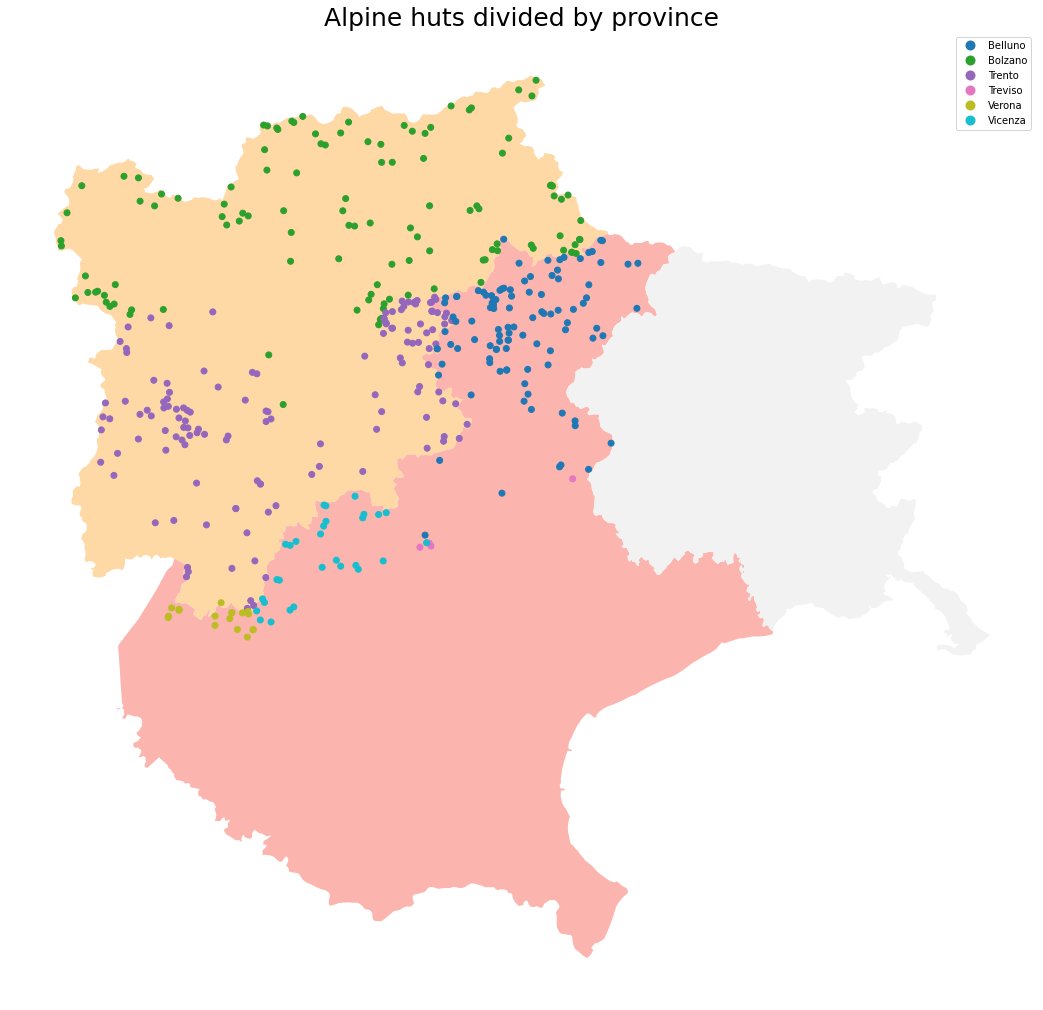

In [40]:
fig, axes = plt.subplots(1,1, figsize=(15,15))

dolomiti_regions.to_crs(epsg=4326).plot(ax=axes, cmap="Pastel1_r", column='DEN_REG')
osm_rifugi.to_crs(epsg=4326).plot(ax=axes, cmap='tab10', column='DEN_PROV', legend=True)

plt.title('Alpine huts divided by province', fontdict=dict(size=25))
plt.tight_layout()
plt.axis('off')
plt.show()

In [30]:
# explore number of huts for each provinces

hut_per_province = {k : len(osm_rifugi.loc[osm_rifugi.DEN_PROV == k]) for k in osm_rifugi.DEN_PROV.dropna().unique()}
for name, value in reversed(sorted(hut_per_province.items(), key=lambda item: item[1])):
  print(f'Number of Hut in {name}: {value}')

Number of Hut in Trento: 136
Number of Hut in Bolzano: 117
Number of Hut in Belluno: 103
Number of Hut in Vicenza: 29
Number of Hut in Verona: 19
Number of Hut in Treviso: 4


Since they are many we will try to create an interactive map with MarkerCluster for better visualize them.

In [29]:
#  https://stackoverflow.com/questions/37466683/create-a-legend-on-a-folium-map
from folium.plugins import MarkerCluster

osm_hut_map = utils.get_new_map(title='Hut divided by region of provenience', tiles=tiles)
colors = ['gray', 'lightgreen', 'green', 'orange', 'darkred','black']

feature_layers = {
    group: FeatureGroup(name=f"<span style='color:{styles.c_colors[idx]}'>Hut in {group}</span>") 
    for idx, group in enumerate(unique_provice_dolomities)
  }

marker_clusters_ops = {
    'zoomToBoundsOnClick': False, 'maxClusterRadius': 110, 'spiderfyOnMaxZoom': 2, 'disableClusteringAtZoom': 10
  }

marker_clusters = {
    group: MarkerCluster(
        options = marker_clusters_ops,
        name = f"<span style='color:{styles.c_colors[idx]}'>Hut in {group}</span>"
      ) 
    for idx, group in enumerate(unique_provice_dolomities)
  }

feature_layers['dolomiti_area'] =  FeatureGroup(name='Area Dolomiti')
dolomiti_geo.add_to(feature_layers['dolomiti_area'])

# add huts to the map
for idx, row in osm_rifugi.iterrows():
  marker_group = row.DEN_PROV
  marker = Marker(
      location = [i[0] for i in reversed(row.geometry.xy)],
      popup = utils.get_info_from_row(row), 
      tooltip = utils.get_info_from_row(row),
      icon = Icon(color = styles.c_colors[unique_provice_dolomities.index(row.DEN_PROV)])
  )
  marker.add_to(marker_clusters[marker_group])

for k,v in marker_clusters.items():
  marker_clusters[k].add_to(feature_layers[k])

utils.add_map_infos(feature_layers, osm_hut_map, collapsed_legend=True)

## &nbsp; 1.3 Alpine huts elevation
Explore the elevation of the huts.

In [41]:
osm_hut_dolomities_map_ele = utils.get_new_map(title='Hut colored according to the elevation', tiles=tiles)

altitudes = [500, 1000, 1500, 2000, 2500, 2800]
colors = ['gray', 'lightgreen', 'green', 'orange', 'darkred','black']

feature_layers = {
    group:FeatureGroup(name=f"<span style='color:{colors[idx]}'>Hut higher than {group}m</span>") 
    for idx, group in enumerate(altitudes)
  }

feature_layers['dolomiti_area'] =  FeatureGroup(name='Area Dolomiti')
dolomiti_geo.add_to(feature_layers['dolomiti_area'])

# huts according to the elevation
for idx, row in osm_rifugi.iterrows():
  if row.ele != 0:
    color, marker_group = styles.hut_style_ele(row.ele)
    marker = Marker(
      location = [i[0] for i in reversed(row.geometry.xy)],
      popup = utils.get_info_from_row(row), 
      tooltip = utils.get_info_from_row(row),
      icon = Icon(color = color)
    )
    marker.add_to(feature_layers[marker_group])

utils.add_map_infos(feature_layers, osm_hut_dolomities_map_ele, collapsed_legend=True)

## &nbsp; 1.4 SAT huts prices

In [67]:
# prices manually collected from the SAT information on prices
huts_prices = pd.read_csv('data/huts_prices.csv', encoding='latin-1',  on_bad_lines='skip', header=[0], sep=";")
sat_rifugi = gpd.read_file("data/alpine_huts/rifugi.shp") 


# create common columns to merge the datasets
idxs = []
for _, row in huts_prices.iterrows():
  for idx, sat in sat_rifugi.iterrows():
    if row["name"] in sat.display_na:
      idxs.append(idx)

huts_prices.index = idxs
huts_prices_merged = huts_prices.merge(sat_rifugi, left_index=True, right_index=True).reset_index(drop=True)
huts_prices_merged = gpd.GeoDataFrame(huts_prices_merged)
huts_prices_merged = huts_prices_merged.to_crs(epsg=4326)
huts_prices_merged.tail(2)

name  elevation categoria  posto_riposo_emergenze  \
26  Rifugio XII Apostoli       2489         d                     5.0   
27       Rifugio Vajolet       2243         c                     5.0   

    posto_letto_soci  posto_letto_non_soci  mezza_pensione_soci  \
26                17                    34                   48   
27                16                    32                   47   

    mezza_pensione_non_soci acqua             municipali  ...  \
26                       58   NaN    San Lorenzo Dorsino  ...   
27                       58   NaN  San Giovanni di Fassa  ...   

              extended_n     opening_ho       contact_mo winter_roo capacity  \
26  Rifugio XII Apostoli  Jun 20-Sep 20  +39 339 8405054        yes       38   
27       Rifugio Vajolet  Jun 20-Sep 20  +39 335 7073258        yes      130   

                            website                      email  \
26    http://www.dodiciapostoli.it/  rifugio@dodiciapostoli.it   
27  https://www.rifugiovajolet.com/    info@rifugiovajolet.com   

                                           display_na  type_descr  \
26  Rifugio XII Apostoli, Via ferrata sentiero Bre...  alpine_hut   
27  Rifugio Vajolet, 546, San Giovanni di Fassa, C...  alpine_hut   

                     geometry  
26  POINT (10.84743 46.15064)  
27  POINT (11.63276 46.45860)  

[2 rows x 23 columns]

In [ ]:
# summarinzing the prices information
cost_indicator_field = [
                        "posto_riposo_emergenze",	
                        "posto_letto_soci",	
                        "posto_letto_non_soci",	
                        "mezza_pensione_soci",	
                        "mezza_pensione_non_soci"
                      ]
cost_indicator = []

for _, row in huts_prices.iterrows():
  cost_indicator.append(
      (row[cost_indicator_field].sum())
  )

huts_prices_merged['cost_indicator'] = cost_indicator

In [ ]:
osm_hut_dolomities_map_ele = utils.get_new_map(title='Hut colored according to the elevation with prices information', tiles=tiles)

altitudes = [500, 1000, 1500, 2000, 2500, 2800]
colors = ['gray', 'lightgreen', 'green', 'orange', 'darkred','black']

feature_layers = {
    group:FeatureGroup(name=f"<span style='color:{colors[idx]}'>Hut higher than {group}m</span>") 
    for idx, group in enumerate(altitudes)
  }

feature_layers['dolomiti_area'] =  FeatureGroup(name='Area Dolomiti')
dolomiti_geo.add_to(feature_layers['dolomiti_area'])

# hut in dolomities according to the elevation
for idx, row in huts_prices_merged.loc[:, ['name', 'elevation', 'categoria', 'extended_n', 'geometry', 'cost_indicator'] + cost_indicator_field].iterrows():
  color, marker_group = styles.hut_style_ele(row.elevation)
  marker = Marker(
      location = [i[0] for i in reversed(row.geometry.xy)],
      popup = utils.get_info_from_row(row), 
      tooltip = utils.get_info_from_row(row),
      icon=folium.Icon(color = color)
  )
  
  marker.add_to(feature_layers[marker_group])

utils.add_map_infos(feature_layers, osm_hut_dolomities_map_ele, collapsed_legend=True)

# &nbsp; 2. Dolomities huts

Select only the huts that are nearby the dolomites

In [42]:
buffered_dolomiti = dolomiti_df.copy()

# buffering on fly on epsg 32632
buffered_dolomiti.geometry = dolomiti_df.to_crs(epsg=32632).geometry.buffer(500).to_crs(epsg=4326).values
hut_in_dolomities_buffer = osm_rifugi.geometry.apply(lambda x: utils.element_within_area(x, buffered_dolomiti, 'name'))
assert buffered_dolomiti.crs == osm_rifugi.crs

# selecting only the huts that are closeby the dolomities
osm_rifugi['dolomities'] = hut_in_dolomities_buffer
osm_dolomites = osm_rifugi.loc[~osm_rifugi.dolomities.isna()].reset_index(drop=True)

In [43]:
print(f'Number of hut in the dolomities: {len(osm_dolomites)}, total hut: {len(osm_rifugi)}')
osm_hut_dolomities_map = utils.get_new_map(title='Hut divided by Dolomities group', tiles=tiles)
unique_dolomities_group = osm_dolomites.dolomities.unique().tolist()

feature_layers = {group:FeatureGroup(name=f"Group of dolomities: {group}") for group in unique_dolomities_group}
feature_layers['dolomiti_area'] =  FeatureGroup(name='Area Dolomiti')
dolomiti_geo.add_to(feature_layers['dolomiti_area'])

# hut in the dolomities
for idx, row in osm_dolomites.iterrows():
  marker_group = row.dolomities
  marker = Marker(
      location = [i[0] for i in reversed(row.geometry.xy)],
      popup = utils.get_info_from_row(row), 
      tooltip = utils.get_info_from_row(row),
      icon = Icon(color=styles.c_colors[unique_dolomities_group.index(row.dolomities)])
  )
  marker.add_to(feature_layers[marker_group])

utils.add_map_infos(feature_layers, osm_hut_dolomities_map, collapsed_legend=True)

Number of hut in the dolomities: 91, total hut: 408


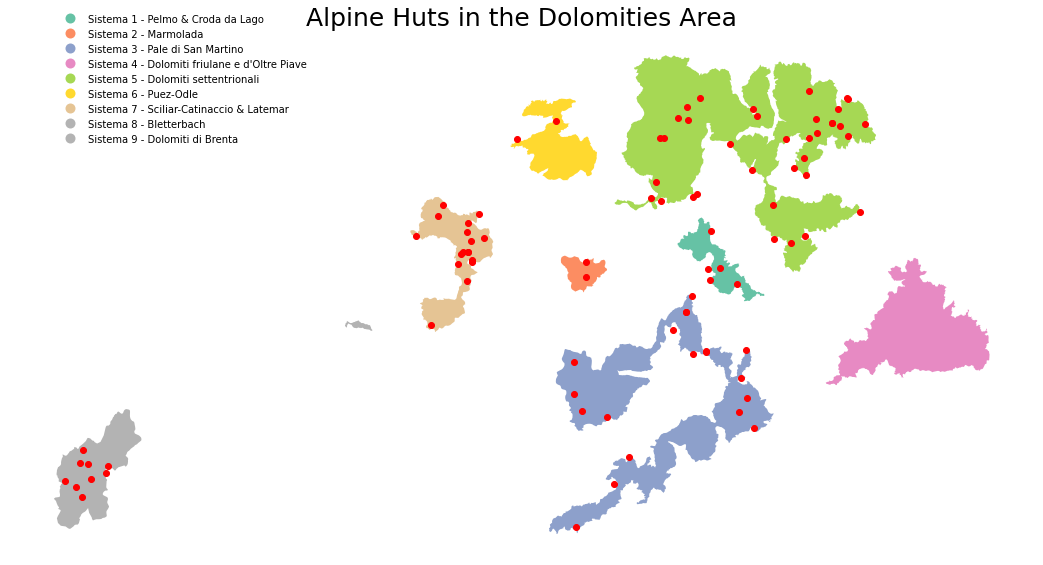

In [63]:
# explore with static maps
fig, axes = plt.subplots(1,1, figsize=(15,15))

dolomiti_df.to_crs(epsg=4326).plot(
    ax=axes,
    column='name',
    cmap = "Set2",
    legend=True,  
    categorical=True,
    legend_kwds= {
        'bbox_to_anchor':(.3, 1.05),
        'fontsize':10,
        'frameon':False
        }
)

osm_dolomites.to_crs(epsg=4326).plot(ax=axes, color = "red")

plt.title('Alpine Huts in the Dolomities Area', fontdict=dict(size=25))
plt.tight_layout()
plt.axis('off')
plt.show()

In [64]:
# exploring the huts for each group of dolomities
hut_per_dolomities = {k : len(osm_dolomites.loc[osm_dolomites.dolomities == k]) for k in osm_dolomites.dolomities.unique()}
for name, value in reversed(sorted(hut_per_dolomities.items(), key=lambda item: item[1])):
  print(f'Number of Hut in {name}: {value}')

Number of Hut in Sistema 5 - Dolomiti settentrionali: 36
Number of Hut in Sistema 3 - Pale di San Martino: 19
Number of Hut in Sistema 7 - Sciliar-Catinaccio & Latemar: 18
Number of Hut in Sistema 9 - Dolomiti di Brenta: 9
Number of Hut in Sistema 1 - Pelmo & Croda da Lago: 5
Number of Hut in Sistema 2 - Marmolada: 2
Number of Hut in Sistema 6 - Puez-Odle: 2


## &nbsp; 2.1 Dolomities huts elevation

In [ ]:
osm_hut_dolomities_map_ele = utils.get_new_map(title='Hut colored according to the elevation', tiles=tiles)

altitudes = [500, 1000, 1500, 2000, 2500, 2800]
colors = ['gray', 'lightgreen', 'green', 'orange', 'darkred','black']

feature_layers = {
    group:FeatureGroup(name=f"<span style='color:{colors[idx]}'>Hut higher than {group}m</span>") 
    for idx, group in enumerate(altitudes)
  }

feature_layers['dolomiti_area'] =  FeatureGroup(name='Area Dolomiti')
dolomiti_geo.add_to(feature_layers['dolomiti_area'])

# hut in dolomities according to the elevation
for idx, row in osm_dolomites.iterrows():
  color, marker_group = styles.hut_style_ele(row.ele)
  marker = Marker(
      location = [i[0] for i in reversed(row.geometry.xy)],
      popup = utils.get_info_from_row(row), 
      tooltip = utils.get_info_from_row(row),
      icon=folium.Icon(color = color)
  )
  
  marker.add_to(feature_layers[marker_group])

utils.add_map_infos(feature_layers, osm_hut_dolomities_map_ele, collapsed_legend=True)

# &nbsp; 3. OSM OverPass API for Peaks

Similar to before we are now able to retrieve the peaks in the selected regions.

query:
```
[out:json][timeout:25];
{{geocodeArea:Trento}}->.searchArea;
(
  // query part for: “peak”
  node["natural"="peak"](area.searchArea);
);
out body;
>;
out skel qt;
```

Doing this for Trento, Veneto, Bolzano.
Since they are many we directly filter them according to their prossimity to the dolomities.

## &nbsp; 3.1 Load the peaks data

In [68]:
osm_peak = pd.concat([
  gpd.read_file('data/peaks/osm_peak_bolzano.geojson'),
  gpd.read_file('data/peaks/osm_peak_trento.geojson'),
  gpd.read_file('data/peaks/osm_peak_veneto.geojson'),                      
  gpd.read_file('data/peaks/osm_peak_friuli.geojson')                        
])

# some preprocess
osm_peak.drop(columns=['id', '@id'], inplace=True)
osm_peak.replace({np.nan: None}, inplace=True)
osm_peak.dropna(subset=['ele'], inplace=True)
osm_peak.ele = osm_peak.ele.astype(float)
osm_peak.head(2)

alt_name alt_name:de alt_name:it alt_name:lld alt_name:vi alt_name_2  \
0     None        None        None         None        None       None   
1     None        None        None         None        None       None   

  artist_name comment description direction  ...  name:es name:sl name:slo  \
0        None    None        None      None  ...     None    None     None   
1        None    None        None      None  ...     None    None     None   

  notes old_name:it old_name:sl old_source:name population short_name:fur  \
0  None        None        None            None       None           None   
1  None        None        None            None       None           None   

  summit:bell  
0        None  
1        None  

[2 rows x 102 columns]

## &nbsp; 3.2 Dolomities Peaks

In [69]:
#check peaks in dolomities
assert osm_peak.crs == buffered_dolomiti.crs
peak_in_dolomities_buffer = osm_peak.geometry.apply(lambda x: utils.element_within_area(x, buffered_dolomiti, 'name'))

osm_peak['dolomities'] = peak_in_dolomities_buffer
osm_dolomites_peak = osm_peak.loc[~osm_peak.dolomities.isna()].reset_index(drop=True)

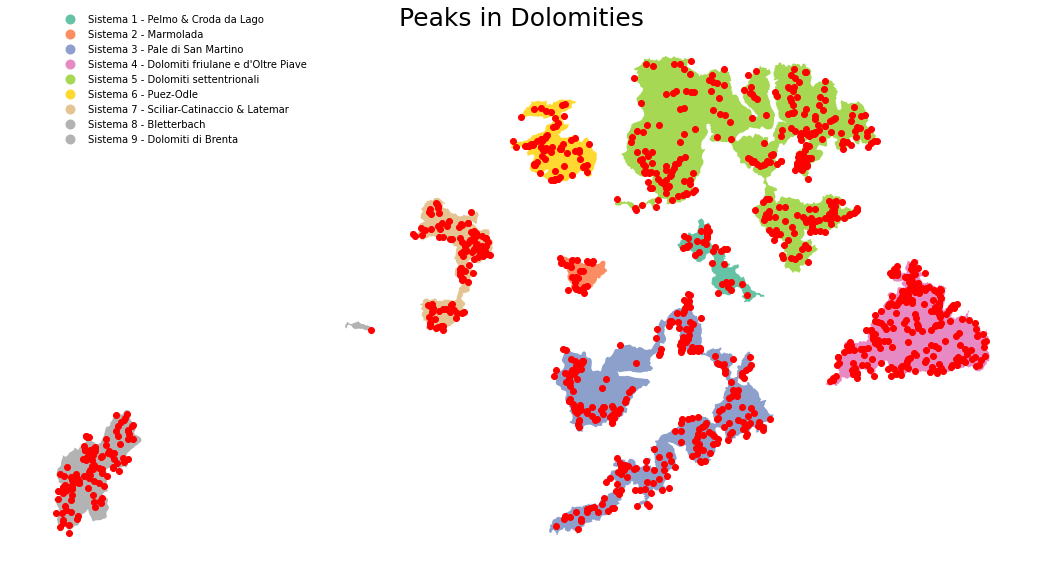

In [76]:
# explore with static maps
fig, axes = plt.subplots(1,1, figsize=(15,15))


dolomiti_df.to_crs(epsg=4326).plot(
    ax=axes,
    column='name',
    cmap = "Set2",
    legend=True,  
    categorical=True,
    legend_kwds= {
        'bbox_to_anchor':(.3, 1.05),
        'fontsize':10,
        'frameon':False
        }
  )

osm_dolomites_peak.to_crs(epsg=4326).plot(ax=axes, color='red')

plt.title('Peaks in Dolomities', fontdict=dict(size=25))
plt.tight_layout()
plt.axis('off')
plt.show()

In [90]:
# municipality for each region that touches the dolomities
for _, row in osm_dolomites_peak.groupby('dolomities').size().sort_values(0, ascending=False).reset_index().iterrows():
  print(f"'{row.dolomities}' has {row[0]} peaks")

'Sistema 5 - Dolomiti settentrionali' has 342 peaks
'Sistema 3 - Pale di San Martino' has 271 peaks
'Sistema 4 - Dolomiti friulane e d'Oltre Piave' has 262 peaks
'Sistema 9 - Dolomiti di Brenta' has 113 peaks
'Sistema 7 - Sciliar-Catinaccio & Latemar' has 104 peaks
'Sistema 6 - Puez-Odle' has 72 peaks
'Sistema 1 - Pelmo & Croda da Lago' has 38 peaks
'Sistema 2 - Marmolada' has 27 peaks
'Sistema 8 - Bletterbach' has 1 peaks


In [70]:
osm_peak_dolomities_map = utils.get_new_map(title='Peak colored according to the elevation', tiles=tiles)

altitudes = [500, 1000, 1500, 2000, 2500, 2800]
colors = ['gray', 'lightgreen', 'green', 'orange', 'darkred','black']

feature_layers = {
    group: FeatureGroup(name=f"<span style='color:{colors[idx]}'>Hut higher than {group}m</span>") 
    for idx, group in enumerate(altitudes)
  }

marker_clusters = {
    group: MarkerCluster(name=f"<span style='color:{colors[idx]}'>Hut higher than {group}m</span>") 
    for idx, group in enumerate(altitudes)
  }

feature_layers['dolomiti_area'] =  FeatureGroup(name='Area Dolomiti')
dolomiti_geo.add_to(feature_layers['dolomiti_area'])

# all peaks according to the elevation
for idx, row in osm_dolomites_peak.iterrows():
  color, marker_group = styles.hut_style_ele(row.ele)
  marker = Marker(
      location = [i[0] for i in reversed(row.geometry.xy)],
      popup = utils.get_info_from_row(row), 
      tooltip = utils.get_info_from_row(row),
      icon=folium.Icon(color=color)
  )

  marker.add_to(marker_clusters[marker_group])

for k,v in marker_clusters.items():
  marker_clusters[k].add_to(feature_layers[k])

utils.add_map_infos(feature_layers, osm_peak_dolomities_map, collapsed_legend=True)

Output hidden; open in https://colab.research.google.com to view.

## &nbsp; 3.3  Peaks' 3000m
Let's inspect the most intersting peaks, the over 3000 meters peaks.

In [98]:
# very high peaks
osm_peak_dolomities_map = utils.get_new_map(title='Dolomities very high peak > 3000', tiles=tiles)

altitudes = [3000, 3100, 3200, 3300]
colors = ['orange', 'red', 'darkred','black']

feature_layers = {
    group:FeatureGroup(name=f"<span style='color:{colors[idx]}'>Hut higher than {group}m</span>") 
    for idx, group in enumerate(altitudes)
  }

feature_layers['dolomiti_area'] =  FeatureGroup(name='Area Dolomiti')
dolomiti_geo.add_to(feature_layers['dolomiti_area'])

for idx, row in osm_dolomites_peak.iterrows():
  if row.ele > 3000:
    color, marker_group = styles.hut_style_ele_high_peak(row.ele)
    marker = Marker(
        location = [i[0] for i in reversed(row.geometry.xy)],
      popup = utils.get_info_from_row(row), 
      tooltip = utils.get_info_from_row(row),
        icon=folium.Icon(color=color)
    )
    
    marker.add_to(feature_layers[marker_group])

utils.add_map_infos(feature_layers, osm_peak_dolomities_map, collapsed_legend=True)

In [97]:
# municipality for each region that touches the dolomities
to_iter = osm_dolomites_peak.loc[osm_dolomites_peak.ele > 3000].groupby('dolomities').size().sort_values(0, ascending=False)
for _, row in to_iter.reset_index().iterrows():
  print(f"'{row.dolomities}' has {row[0]} high peaks")

'Sistema 5 - Dolomiti settentrionali' has 24 high peaks
'Sistema 3 - Pale di San Martino' has 10 high peaks
'Sistema 2 - Marmolada' has 8 high peaks
'Sistema 9 - Dolomiti di Brenta' has 8 high peaks
'Sistema 1 - Pelmo & Croda da Lago' has 3 high peaks
'Sistema 6 - Puez-Odle' has 2 high peaks
'Sistema 7 - Sciliar-Catinaccio & Latemar' has 1 high peaks


# &nbsp; 4. Dolomities Huts and Peaks
Let's try to understand the Hut that are very close to some peaks

## &nbsp; 4.1 Huts close to Peaks

In [101]:
# https://github.com/napo/geospatial_course_unitn/blob/master/code/solutions/02_exercise_spatial_relationship_and_operations.ipynb
from shapely.ops import nearest_points

def get_closest_point(peak, hut_unary, hut_dataset):
  _, hut = nearest_points(peak, hut_unary)
  return hut_dataset.loc[hut_dataset.geometry == hut].name.values[0]

hut_unary = osm_dolomites.geometry.unary_union
assert osm_dolomites_peak.crs == osm_dolomites.crs

osm_dolomites_high_peak = osm_dolomites_peak.copy()
osm_dolomites_high_peak = osm_dolomites_high_peak.loc[osm_dolomites_high_peak.ele > 3000]
osm_dolomites_high_peak['closest_hut'] = osm_dolomites_high_peak.geometry.apply(lambda x: get_closest_point(x, hut_unary, osm_dolomites))

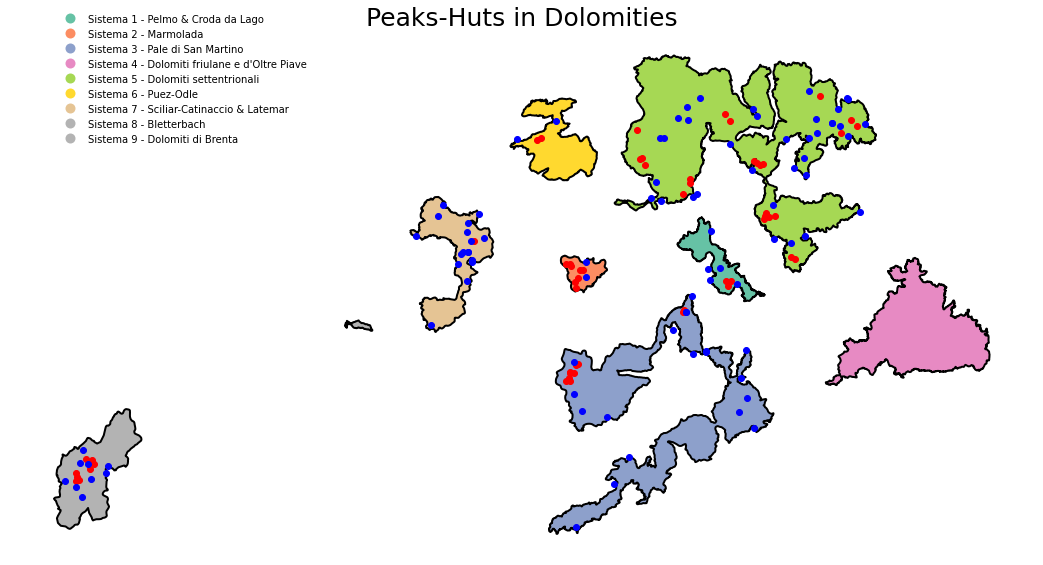

In [110]:
fig, axes = plt.subplots(1,1, figsize=(15,15))

dolomiti_df.to_crs(epsg=4326).plot(
    ax=axes,
    linewidth=2,
    edgecolor='black',
    column='name',
    cmap = "Set2",
    legend=True,  
    categorical=True,
    legend_kwds= {
        'bbox_to_anchor':(.3, 1.05),
        'fontsize':10,
        'frameon':False
        }
)

osm_dolomites_high_peak.to_crs(epsg=4326).plot(ax=axes, color = "red")
osm_dolomites.to_crs(epsg=4326).plot(ax=axes, color = "blue")

plt.title('Peaks-Huts in Dolomities', fontdict=dict(size=25))
plt.tight_layout()
plt.axis('off')
plt.show()

In [118]:
for idx, row in osm_dolomites_high_peak.iterrows():
  s = f"Peak '{row['name']}'"
  s += " "*(50 - len(s))
  print(f"{s} -> '{row['closest_hut']}'")

Peak 'Kesselkogel - Catinaccio d'Antermoia'        -> 'Rifugio Passo Principe - Grasleitenpasshütte'
Peak 'Cima Undici'                                 -> 'Rifugio Carducci'
Peak 'Sas Rigais'                                  -> 'Brogleshütte'
Peak 'Dreischusterspitze - Punta tre scarperi'     -> 'Dreischusterhütte - Rifugio Tre Scarperi'
Peak 'Piz de Lavarela'                             -> 'Ütia de Scotoni - Scotoni-Hütte - Rifugio Scotoni'
Peak 'La Furchёta'                                 -> 'Schlüterhütte - Rifugio Genova'
Peak 'Piz dles Cunturines'                         -> 'Ütia de Scotoni - Scotoni-Hütte - Rifugio Scotoni'
Peak 'Monte Popera'                                -> 'Rifugio Antonio Berti'
Peak 'Piza dales Diesc'                            -> 'Lavarellahütte'
Peak 'Lavarela de Fora'                            -> 'Ütia de Scotoni - Scotoni-Hütte - Rifugio Scotoni'
Peak 'Cima Brenta'                                 -> 'Rifugio Alimonta'
Peak 'Cima Tosa'                 

In [119]:
osm_peak_hut_dolomities_map = utils.get_new_map(title='Hut close to the highest Peaks', tiles=tiles)

groups = ['peak', 'hut']
colors = ['darkred', 'blue']

feature_layers = {
    group:FeatureGroup(name=f"<span style='color:{colors[idx]}'>{group.capitalize()}</span>") 
    for idx, group in enumerate(groups)
  }

feature_layers['dolomiti_area'] =  FeatureGroup(name='Area Dolomiti')
dolomiti_geo.add_to(feature_layers['dolomiti_area'])

# high peak
for idx, row in osm_dolomites_high_peak.iterrows():
  marker = Marker(
      location = [i[0] for i in reversed(row.geometry.xy)],
      popup = utils.get_info_from_row(row), 
      tooltip = utils.get_info_from_row(row),
      icon=folium.Icon(color='darkred')
  )

  marker.add_to(feature_layers['peak'])

# hut closesest to the highest peaks
set_uniques = osm_dolomites_high_peak['closest_hut'].unique()
for idx, row in osm_dolomites.loc[osm_dolomites.name.isin(set_uniques)].iterrows():
  marker = Marker(
      location = [i[0] for i in reversed(row.geometry.xy)],
      popup = utils.get_info_from_row(row), 
      tooltip = utils.get_info_from_row(row),
      icon=folium.Icon(color='blue')
  )
  marker.add_to(feature_layers['hut'])

utils.add_map_infos(feature_layers, osm_peak_hut_dolomities_map, collapsed_legend=True)

## &nbsp; 4.2 Absolute distances
compute the absolute distance between the peaks and its closests hut. Moreover we define the shortest absolute path between the peak and the hut (straight line from one point to the other).

In [127]:
res = []
osm_dolomites_32632 = osm_dolomites.to_crs(epsg=32632)
osm_dolomites_high_peak.reset_index(inplace=True, drop=True)

# find the distance in absolute terms
assert osm_dolomites_32632.crs == osm_dolomites_high_peak.to_crs(epsg=32632).crs
for idx, row in osm_dolomites_high_peak.to_crs(epsg=32632).iterrows():
  peak = row["geometry"]
  hut = osm_dolomites_32632.loc[osm_dolomites_32632['name'] == row["closest_hut"]].geometry.values[0]
  res.append({'distance' : round(peak.distance(hut))})

# find the absolute path from a -> b (for very proficient trekkers :P).
assert osm_dolomites_high_peak.crs == osm_dolomites.crs
for idx, row in osm_dolomites_high_peak.iterrows():
  peak = row["geometry"]
  hut = osm_dolomites.loc[osm_dolomites['name'] == row["closest_hut"]].geometry.values[0]
  res[idx]['geometry'] = shapely.geometry.LineString([peak,hut])
      
linestring_distance = gpd.GeoDataFrame(res, crs="EPSG:4326") 

In [131]:
osm_peak_hut_dolomities_map = utils.get_new_map(title='Shortest Path between peaks and huts', tiles=tiles)
groups = ['peak', 'hut', 'peak_hut_path']
colors = ['darkred', 'blue', 'black']

feature_layers = {
    group:FeatureGroup(name=f"<span style='color:{colors[idx]}'>{group.capitalize()}</span>") 
    for idx, group in enumerate(groups)
  }

feature_layers['dolomiti_area'] =  FeatureGroup(name='Area Dolomiti')
dolomiti_geo.add_to(feature_layers['dolomiti_area'])

# peaks
for idx, row in osm_dolomites_high_peak.iterrows():
  marker = Marker(
    location = [i[0] for i in reversed(row.geometry.xy)],
    popup = utils.get_info_from_row(row), 
    tooltip = utils.get_info_from_row(row),
    icon=folium.Icon(color='darkred')
  )
  marker.add_to(feature_layers['peak'])


# huts close to the peaks
set_uniques = osm_dolomites_high_peak['closest_hut'].unique()
for idx, row in osm_dolomites.loc[osm_dolomites.name.isin(set_uniques)].iterrows():
  marker = Marker(
    location = [i[0] for i in reversed(row.geometry.xy)],
    popup = utils.get_info_from_row(row), 
    tooltip = utils.get_info_from_row(row),
    icon=folium.Icon(color='blue')
  )
  marker.add_to(feature_layers['hut'])


# Linestring huts-peaks
for idx, row in linestring_distance.iterrows():
  info = f'distance {row.distance}'
  line = folium.PolyLine(
    locations = [list(reversed(i)) for i in list(row.geometry.coords)],
    popup = info, 
    tooltip = info,
    color='black',
    weight=10,
  )

  line.add_to(feature_layers['peak_hut_path'])

feature_layers['dolomiti_area'].add_to(osm_peak_hut_dolomities_map)
utils.add_map_infos(feature_layers, osm_peak_hut_dolomities_map, collapsed_legend=True)

in the next notebook we will consider the SAT trail of the Trentino area.